# GPU 확인 코드

In [1]:
!nvidia-smi

Mon Nov 30 12:57:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |   6722MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# GPU 할당

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

# Pretrained Model 구조 확인

In [3]:
from tensorflow.keras.applications import DenseNet201

model_base = DenseNet201(weights='imagenet',
                             include_top=False,
                             input_shape=(224,224,3))
print(model_base.summary())

74842112/74836368 [==============================] - 4s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________

# Import 코드

In [3]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import DenseNet201
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import DenseNet201

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True



# Mask Img 파일 DataFrame에 정렬

In [4]:
# path = './'
# mask = 0
# no_mask = 1

mask_path = '/home/lab07/with_mask_sum_MTCNN_GRAY'
no_mask_path = '/home/lab07/without_mask_sum_MTCNN_GRAY'


file = []
for filename in os.listdir(mask_path ):
    file.append(mask_path + '/' + filename)

mask_df = pd.DataFrame(columns = ['file','label'])
mask_df['file'] = file
mask_df['label'] = 0
print(mask_df[:3])

file = []
for filename in os.listdir(no_mask_path ):
    file.append(no_mask_path + '/' + filename)

no_mask_df = pd.DataFrame(columns = ['file','label'])
no_mask_df['file'] = file
no_mask_df['label'] = 1
print(no_mask_df[:3])

                                                file  label
0  /home/lab07/with_mask_sum_MTCNN_GRAY/Mask_5602...      0
1  /home/lab07/with_mask_sum_MTCNN_GRAY/Mask_3104...      0
2  /home/lab07/with_mask_sum_MTCNN_GRAY/Mask_7154...      0
                                                file  label
0  /home/lab07/without_mask_sum_MTCNN_GRAY/Mask_5...      1
1  /home/lab07/without_mask_sum_MTCNN_GRAY/Mask_3...      1
2  /home/lab07/without_mask_sum_MTCNN_GRAY/seed48...      1


# Data를 train, val 구분

In [5]:
df = pd.concat([mask_df, no_mask_df], axis=0)
train_df, valid_df = train_test_split(df, test_size=0.2, random_state = 25, stratify = df['label'])
# train_df, test_df = train_test_split(train_df, test_size=0.2, random_state = 25, stratify = train_df['label'])

print(train_df['label'].value_counts())
print(valid_df['label'].value_counts())

0    16035
1    15461
Name: label, dtype: int64
0    4009
1    3865
Name: label, dtype: int64


# 학습에 필요한 Data 생성

In [6]:
batch_size = 20
image_size = (224,224)
# image_size = (256,256)

train_datagen = ImageDataGenerator(rescale=1./255,)
validation_datagen = ImageDataGenerator(rescale=1./255,)


train_generator  = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'file',
    y_col = 'label',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'raw',
    shuffle=True,
#     color_mode = 'grayscale'
    )

validation_generator  = validation_datagen.flow_from_dataframe(
    valid_df,
    x_col = 'file',
    y_col = 'label',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'raw',
    shuffle=False
    )

train_ep = len(train_generator)
val_ep = len(validation_generator)

print(train_ep)
print(val_ep)



Found 31496 validated image filenames.
Found 7874 validated image filenames.
1575
394


# 모델 학습

## 1. Densenet201

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 94080)             0         
_________________________________________________________________
dense (Dense)                (None, 738)               69431778  
_________________________________________________________________
batch_normalization (BatchNo (None, 738)               2952      
_________________________________________________________________
dense_1 (Dense)              (None, 738)               545382    
_________________________________________________________________
batch_normalization_1 (Batch (None, 738)               2952      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7

Epoch 3/25
1575/1575 [==============================] - 212s 135ms/step - loss: 4.4132e-04 - accuracy: 0.9999 - val_loss: 0.0014 - val_accuracy: 0.9994
Epoch 4/25
1575/1575 [==============================] - 210s 134ms/step - loss: 8.4675e-04 - accuracy: 0.9998 - val_loss: 0.0015 - val_accuracy: 0.9992
Epoch 5/25
1575/1575 [==============================] - 212s 135ms/step - loss: 4.1028e-04 - accuracy: 0.9999 - val_loss: 0.0014 - val_accuracy: 0.9992
Epoch 6/25
1575/1575 [==============================] - 212s 134ms/step - loss: 4.1496e-04 - accuracy: 0.9999 - val_loss: 0.0015 - val_accuracy: 0.9994
Epoch 7/25
1575/1575 [==============================] - 212s 134ms/step - loss: 2.2233e-04 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 0.9994
Epoch 8/25
1575/1575 [==============================] - 212s 134ms/step - loss: 4.7045e-04 - accuracy: 0.9999 - val_loss: 0.0022 - val_accuracy: 0.9991
Epoch 9/25
1575/1575 [==============================] - 212s 135ms/step - loss: 1.8752e-

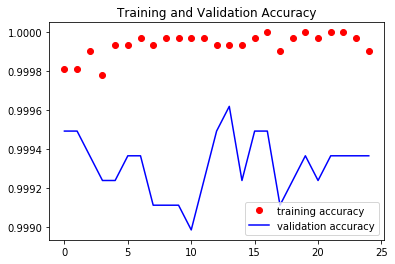

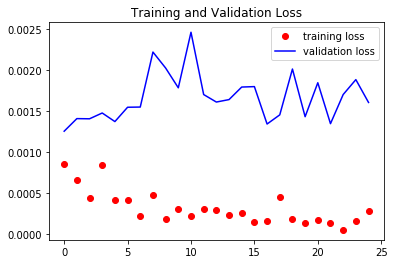

In [12]:

with tf.device('/device:GPU:0'):
    model_base = DenseNet201(weights='imagenet',
                             include_top=False,
                             input_shape=(224,224,3))

    model_base.trainable = False  # Convolution Layer 완전 동결

    model = Sequential()
    model.add(model_base)
    model.add(Flatten(input_shape=(7*7*1920,)))

    model.add(Dense(738,
                    activation='relu'))
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    
    model.add(Dense(738,
                    activation='relu'))
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))

    model.add(Dense(1,
                    activation='sigmoid'))

    model.summary()
    
    lr = 2e-6
    ep = 20
    
    model.compile(optimizer=Adam(learning_rate = lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    best_weights_file="weights2.best.hdf5"
    checkpoint = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

    
    history = model.fit(train_generator,
                        callbacks = [checkpoint],
                        steps_per_epoch = train_ep,
                        epochs = ep,
                        validation_data = validation_generator,
                        validation_steps = val_ep,
                        verbose = 1)
    
    
    model_base.trainable = False
    fine_tune = 43

    # `fine_tune_at` 층 이전의 모든 층을 고정
    for layer in model_base.layers[-fine_tune:]:
          layer.trainable = True

    ## learning rate를 줄이는게 일반적(미세조절)        
    model.compile(optimizer=Adam(learning_rate = lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    ## 재학습 진행
    history = model.fit(train_generator,
                             callbacks = [checkpoint],
                             steps_per_epoch = train_ep,
                             epochs = ep+5,
                             validation_data = validation_generator,
                             validation_steps = val_ep,
                             verbose = 1)

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(train_acc, 'bo', color='r', label='training accuracy')
    plt.plot(val_acc, 'b', color='b', label='validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(train_loss, 'bo', color='r', label='training loss')
    plt.plot(val_loss, 'b', color='b', label='validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    

    model.save('./Model_predict/test_mask_model_Densenet201.h5')

## 2. InceptionV3

In [7]:
from tensorflow.keras.applications import InceptionV3

model_base = InceptionV3(weights='imagenet',
                             include_top=False,
                             input_shape=(224,224,3))
print(model_base.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 738)               37786338  
_________________________________________________________________
batch_normalization_188 (Bat (None, 738)               2952      
_________________________________________________________________
dropout (Dropout)            (None, 738)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 738)               545382    
_________________________________________________________________
batch_normalization_189 (Bat (None, 738)               2

1575/1575 [==============================] - 153s 97ms/step - loss: 0.0057 - accuracy: 0.9979 - val_loss: 0.0049 - val_accuracy: 0.9991
Epoch 8/20
1575/1575 [==============================] - 155s 98ms/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 0.0047 - val_accuracy: 0.9991
Epoch 9/20
1575/1575 [==============================] - 152s 97ms/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 0.0051 - val_accuracy: 0.9987
Epoch 10/20
1575/1575 [==============================] - 152s 96ms/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 0.0055 - val_accuracy: 0.9987
Epoch 11/20
1575/1575 [==============================] - 152s 96ms/step - loss: 0.0044 - accuracy: 0.9984 - val_loss: 0.0051 - val_accuracy: 0.9989
Epoch 12/20
1575/1575 [==============================] - 154s 98ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0056 - val_accuracy: 0.9989
Epoch 13/20
1575/1575 [==============================] - 155s 98ms/step - loss: 0.0040 - accuracy: 0.9986 - val_loss: 0.0055 -

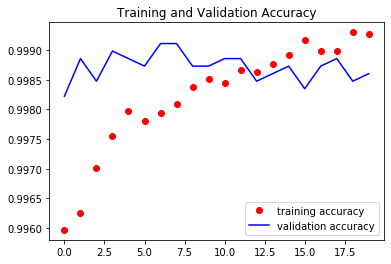

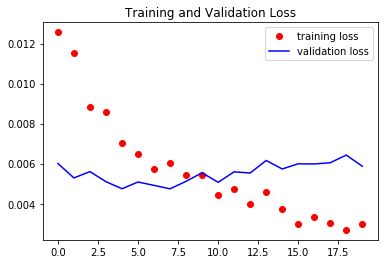

In [8]:

with tf.device('/device:GPU:0'):
    model_base = InceptionV3(weights='imagenet',
                             include_top=False,
                             input_shape=(224,224,3))

    model_base.trainable = False  # Convolution Layer 완전 동결

    model = Sequential()
    model.add(model_base)
    model.add(Flatten(input_shape=(5*5*2048,)))

    model.add(Dense(738,
                    activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(738,
                    activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1,
                    activation='sigmoid'))

    model.summary()
    
    lr = 2e-6
    ep = 15
    
    model.compile(optimizer=Adam(learning_rate = lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    best_weights_file="weights2.best.hdf5"
    checkpoint = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

    
    history = model.fit(train_generator,
                        callbacks = [checkpoint],
                        steps_per_epoch = train_ep,
                        epochs = ep,
                        validation_data = validation_generator,
                        validation_steps = val_ep,
                        verbose = 1)
    
    
    model_base.trainable = False
    fine_tune = 30
    
    # `fine_tune_at` 층 이전의 모든 층을 고정
    for layer in model_base.layers[-fine_tune:]:
          layer.trainable = True

    ## learning rate를 줄이는게 일반적(미세조절)        
    model.compile(optimizer=Adam(learning_rate = lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    ## 재학습 진행
    history = model.fit(train_generator,
                             callbacks = [checkpoint],
                             steps_per_epoch = train_ep,
                             epochs = ep+5,
                             validation_data = validation_generator,
                             validation_steps = val_ep,
                             verbose = 1)

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(train_acc, 'bo', color='r', label='training accuracy')
    plt.plot(val_acc, 'b', color='b', label='validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(train_loss, 'bo', color='r', label='training loss')
    plt.plot(val_loss, 'b', color='b', label='validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    

    model.save('./Model_predict/test_mask_model_inceptionv3_nodrop.h5')